# Jan Izydorczyk
# Airly Data Science project

## Goal

Testing the interpolation efficiency of the *IDW* method for determining the value of the *pm10* for places where no measurements were taken.

## Implementation

For every measurement there is at most 56 distinct sensors (some of values are not corect), not enough to split data to training and test sets (with assumption, that hourly measurments are independet to each other).


For every hour every valid value from the each sensor will be interpolated, using other ones. *idw_err* function returns difference between valid measuremt and interpolation (or 0, if there were no valid value).

The model parameter searched for will be the exponent of the power of the distance function in the IDW interpolation formula, *p*.

Model will minimize *RSS*, using *scipy.minimize* with default parameters.  
$$
RSS = \sum_{i=1}^{N}(w_i-e_i)^2
$$

where $w_i$ is measured value from testing set and $e_i$ is interpolated value.

## Evaluation metric

Evaluation will be done with a mean of absolute relative error for interpolated values:
$$\sum_{i=1}^{N}|\frac{w_i-e_i}{w_i}| $$

## Imports

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from mpmath import mpf, nstr

## Dataset
Dataset is storred locally, for convinience.

In [77]:
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

data = []

for month in months:
    data.append(pd.read_csv(f'data/{month}-2017.csv'))
data = pd.concat(data)
data = data.filter(regex='pm10', axis=1).to_numpy()
nan_mask = np.isnan(data)
_ = np.nan_to_num(data, copy=False) # set to zero

Sensors are sorted in asscendig order relative to their ID, there is no purpose for storing it.

In [18]:
sensors = pd.read_csv('data/sensor_locations.csv')
sensors = sensors.to_numpy()[:, [1, 2]]

## Distance matrix

Distance between all pair of the sensors is cached in **distance_matrix**, for optimalization reasons.  

Sensors are so close to each other, so we can assume that Euclidian metric can approximate proportional distance between them.

In [55]:
def make_dist_mat(points, metric):
    dist_mat = cdist(points, points, metric=metric)
    np.fill_diagonal(dist_mat, 1)
    return dist_mat

In [56]:
dist_mat = make_dist_mat(sensors, lambda a, b: np.linalg.norm(a - b))

## IDW implementation

In [78]:
def idw_err(dist_mat, data, p, nan_mask=nan_mask):
    
    inv_mat = 1 / dist_mat**p
    
    # sensors do not ought to interpolate itself ;)
    np.fill_diagonal(inv_mat, 0) 
    
    res = data @ inv_mat
    
    
    # calculate sum of inverse distancec for each interpolation
    # ignoring not proper values
    inv_sums = np.copy(data)
    proper_mask = ~nan_mask
    inv_sums[proper_mask] = 1
    inv_sums = inv_sums @ inv_mat
    res[proper_mask] = res[proper_mask] / inv_sums[proper_mask]
    
    diff = data - res
    diff[nan_mask] = 0
    return diff

## Finding best p value

In [81]:
guess = 2
rss = lambda p: np.mean(idw_err(dist_mat, data, p[0])[~nan_mask]**2)
res = minimize(rss, (guess,), bounds=[(0, 5)])

In [82]:
print(res)

      fun: 193.20666853939846
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52651288e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.30937512])


## Results

In [94]:
%matplotlib notebook

<IPython.core.display.Javascript object>


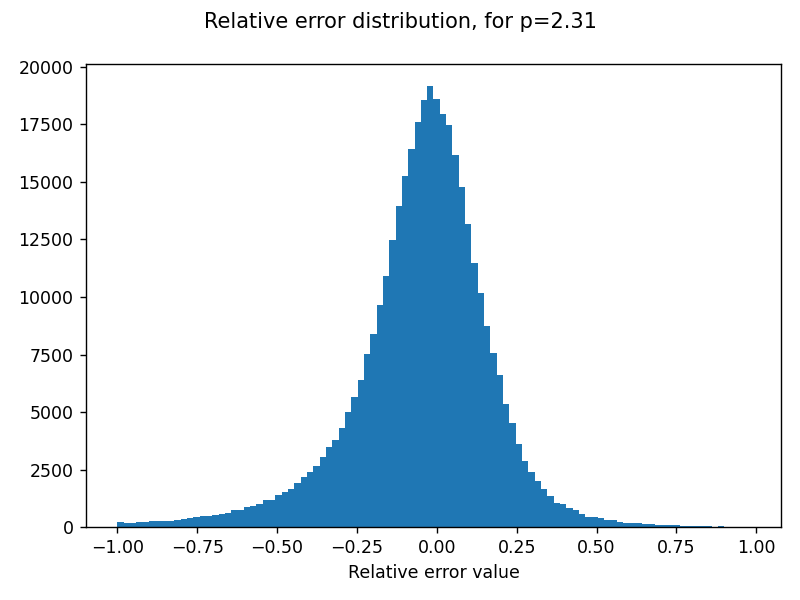

                   0
count  382885.000000
mean       -0.045532
std         0.215528
min        -0.999931
25%        -0.147620
50%        -0.027925
75%         0.079858
max         0.979197


In [98]:
p = res.x[0]
err = idw_err(dist_mat=dist_mat, data=data, p=p)
mask = ~nan_mask & (data != 0) 
err = err[mask].flatten()
err = err / data[mask].flatten()
err = err[(-1 < err) & (err < 1)]
fig = plt.figure()
plt.hist(err, bins=100)
fig.suptitle(f'Relative error distribution, for p={nstr(mpf(p),3)}')
plt.xlabel('Relative error value')
fig.tight_layout()
plt.show()
print(pd.DataFrame(err).describe())

<IPython.core.display.Javascript object>


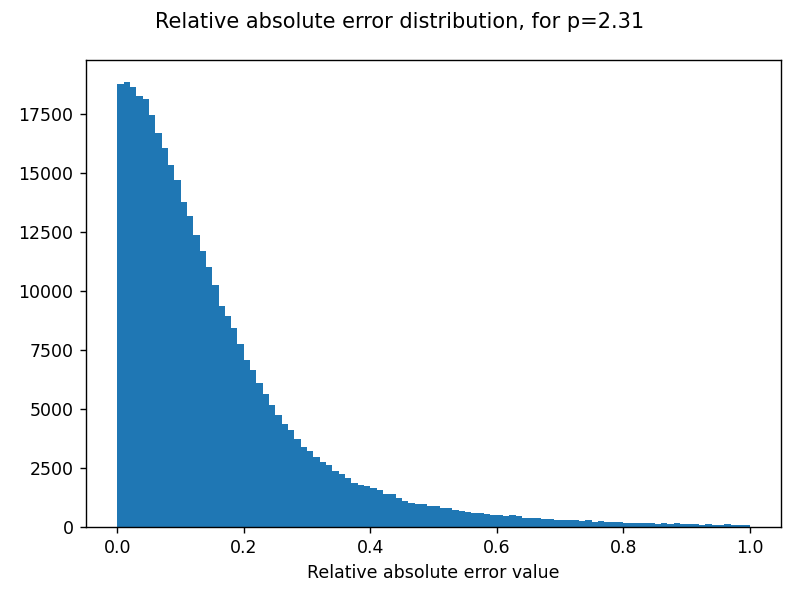

                  0
count  3.828850e+05
mean   1.579762e-01
std    1.535215e-01
min    7.165673e-07
25%    5.175462e-02
50%    1.135924e-01
75%    2.107144e-01
max    9.999307e-01


In [101]:
fig = plt.figure()
plt.hist(np.abs(err), bins=100)
fig.suptitle(f'Relative absolute error distribution, for p={nstr(mpf(p),3)}')
plt.xlabel('Relative absolute error value')
fig.tight_layout()
plt.show()
print(pd.DataFrame(np.abs(err)).describe())

## Conclusion


IDW method has the best result for $p=2.31$. 


Mean of absolute relative error equals $15.8\%$, median equals $11.4\%$. Model is based only on 57 sensors and one parameter *pm10* (which haven't been filtered and shouldn't be fully trusted).

Under these conditions, this order of error is acceptable and can predict other values in a non-worst way. 